# PI-DeepONet for 1D Helmholtz on [0,1] with Dirichlet BC (soft)

This notebook trains a **physics-informed DeepONet** to approximate the solution operator of the 1D Helmholtz/wave equation
\[ u''(x) + k^2\,u(x) = f(x), \quad x\in[0,1], \]

with **branch input** = samples of the forcing function *f* at **Chebyshev sensors** (first kind, in *t*∈[-1,1]) and **trunk input** = spatial coordinates *x*∈[0,1].

- We enforce **Dirichlet BC** as a **soft penalty**: \(|u(0)|^2 + |u(1)|^2\).
- To evaluate series or random forcings in Chebyshev basis, we map *x*→*t*=2x−1.

**What you can change quickly:** `m_sensors` (branch sensors), `width/depth` (nets), `B_batch/N_col` (batch & collocation), `k_min/k_max` (wavenumber range), and forcing generation.

**References (background):** DeepONet (branch+trunk, inner product) and physics‑informed DeepONet; Helmholtz PINN demos provide residual/BC patterns.


In [1]:
# Environment & imports
import math, time, numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt

device = ("cuda" if torch.cuda.is_available()
          else "mps" if getattr(torch.backends, 'mps', None) and torch.backends.mps.is_available()
          else "cpu")
print('Using device:', device)
torch.set_default_dtype(torch.float32)
_ = torch.manual_seed(1234)


Using device: mps


## Configuration
We work on **[0,1]** and use Chebyshev sensors in *t*∈[-1,1] for the branch input (sensing *f*).


In [2]:
# === Config ===
m_sensors   = 64      # number of Chebyshev sensors for branch input f (in t-space)
width       = 128     # feature width (branch/trunk)
depth       = 3       # hidden layers in branch/trunk
B_batch     = 16      # functions per batch (operator learning)
N_col       = 256     # collocation points per function
N_bc        = 2       # BC points per boundary per function (at x=0 and x=1)
steps       = 4000    # training steps
lr          = 1e-3    # learning rate

# Distribution for k
k_min, k_max = 2.0, 10.0

# Random forcing generator: Chebyshev series with decaying coefficients (in t-space)
Nf_terms = 12         # number of Chebyshev terms for random f
decay    = 0.8        # geometric decay factor for coeff magnitudes (0<decay<1)

# Loss weights
w_pde, w_bc = 1.0, 1.0


## Chebyshev utilities
- **Sensors (first kind)** in *t*∈[-1,1]: \t\(\xi_j=\cos\tfrac{(2j+1)\pi}{2m}\).
- Evaluate Chebyshev basis via 3-term recurrence.


In [12]:
def cheb_sensors(m):
    j = torch.arange(m, dtype=torch.float32, device=device)
    xi = torch.cos((2*j+1)*math.pi/(2*m))
    return xi.to(torch.float32)

def cheb_basis(t, n_terms):
    """Return [T0(t),...,T_{n-1}(t)] as a matrix of shape (len(t), n_terms).
    t: (N,1) or (N,) torch tensor in [-1,1]
    """
    t = t.view(-1,1)
    N = t.shape[0]
    T = torch.zeros(N, n_terms, device=device)
    if n_terms>=1: T[:,0] = 1.0
    if n_terms>=2: T[:,1] = t[:,0]
    for n in range(2, n_terms):
        T[:,n] = 2*t[:,0]*T[:,n-1] - T[:,n-2]
    return T

def cheb_eval(t_points, coeffs):
    # t_points: (P,1) in [-1,1]; coeffs: (B, Nf_terms)
    B = coeffs.shape[0]
    T = cheb_basis(t_points, Nf_terms)           # (P, Nf_terms)
    f_vals = T @ coeffs.T                         # (P, B)
    return f_vals.T.unsqueeze(-1)                # (B, P, 1)


def cheb_eval_batched(t_per_batch, coeffs, n_terms=None):
    """t_per_batch: (B, N, 1), coeffs: (B, Nf) -> (B, N, 1)"""
    if n_terms is None:
        n_terms = coeffs.shape[1]
    B, N, _ = t_per_batch.shape
    T = cheb_basis(t_per_batch.reshape(-1, 1), n_terms).reshape(B, N, n_terms)  # (B,N,Nf)
    return torch.bmm(T, coeffs.unsqueeze(-1))  # (B,N,1)


## DeepONet (branch + trunk)
Output is feature inner product between branch(f-samples) and trunk(x).


In [30]:
class BranchNet(nn.Module):
    def __init__(self, m, width=128, depth=3, act=nn.Tanh):
        super().__init__()
        layers = [nn.Linear(m, width), act()]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), act()]
        self.net = nn.Sequential(*layers)
    def forward(self, f_samples):
        return self.net(f_samples)

class TrunkNet(nn.Module):
    def __init__(self, width=128, depth=3, act=nn.Tanh):
        super().__init__()
        layers = [nn.Linear(1, width), act()]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), act()]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class DeepONet(nn.Module):
    def __init__(self, m, width=128, depth=3):
        super().__init__()
        self.branch = BranchNet(m, width, depth)
        self.trunk  = TrunkNet(width, depth)
        self.bias   = nn.Parameter(torch.zeros(1))
    def forward(self, f_batch, x_batch):
        # f_batch: (B, m), x_batch: (B*N, 1)
        B, m = f_batch.shape
        N     = x_batch.shape[0] // B
        bfeat = self.branch(f_batch)                 # (B, W)
        tfeat = self.trunk(x_batch)                  # (B*N, W)
        btile = bfeat.repeat_interleave(N, dim=0)    # (B*N, W)
        u = (btile * tfeat).sum(dim=1, keepdim=True) + self.bias
        return u

model = DeepONet(m_sensors, width=width, depth=depth).to(device)
print('Params:', sum(p.numel() for p in model.parameters()))


Params: 74625


## Forcing generator and batches (domain [0,1])
- Branch sensors are Chebyshev points **in t-space** (we store values of f at x_sens=(xi+1)/2).
- Collocation points are drawn in **x∈[0,1]**; for evaluating f(x) from the Chebyshev series, we map **t=2x−1**.


In [18]:
xi = cheb_sensors(m_sensors).to(device)        # (m,) in t-space [-1,1]
xi

tensor([ 0.9997,  0.9973,  0.9925,  0.9853,  0.9757,  0.9638,  0.9495,  0.9330,
         0.9142,  0.8932,  0.8701,  0.8449,  0.8176,  0.7883,  0.7572,  0.7242,
         0.6895,  0.6532,  0.6152,  0.5758,  0.5350,  0.4929,  0.4496,  0.4052,
         0.3599,  0.3137,  0.2667,  0.2191,  0.1710,  0.1224,  0.0736,  0.0245,
        -0.0245, -0.0736, -0.1224, -0.1710, -0.2191, -0.2667, -0.3137, -0.3599,
        -0.4052, -0.4496, -0.4929, -0.5350, -0.5758, -0.6152, -0.6532, -0.6895,
        -0.7242, -0.7572, -0.7883, -0.8176, -0.8449, -0.8701, -0.8932, -0.9142,
        -0.9330, -0.9495, -0.9638, -0.9757, -0.9853, -0.9925, -0.9973, -0.9997],
       device='mps:0')

In [7]:
xi = cheb_sensors(m_sensors).to(device)        # (m,) in t-space [-1,1]

def sample_k(B):
    return k_min + (k_max - k_min)*torch.rand(B, 1, device=device)

def sample_random_f(B):
    coeffs = torch.randn(B, Nf_terms, device=device)
    scales = (decay ** torch.arange(Nf_terms, device=device)).view(1, -1)
    return coeffs * scales

def batch_data(B=B_batch, N=N_col, Nbc=N_bc):
    # sample functions and k
    k_vals = sample_k(B)
    coeffs = sample_random_f(B)
    # branch sensors: values at x_sens = (xi+1)/2 -> t=xi
    f_sens = cheb_eval(xi.view(-1,1), coeffs).squeeze(-1)   # (B, m)
    # collocation in [0,1]
    x_col  = torch.rand(B, N, 1, device=device)
    # boundary points at 0 and 1
    xL = torch.zeros(B, Nbc, 1, device=device)
    xR = torch.ones(B, Nbc, 1, device=device)
    return coeffs, k_vals, f_sens, x_col, xL, xR


## Physics‑informed loss and training step
Residual: \r = u'' + k^2 u - f(x)\. We compute second derivatives via autograd.


In [15]:
mse = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=lr)

def pde_residual(u, x):
    du = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                             create_graph=True, retain_graph=True)[0]
    d2u = torch.autograd.grad(du, x, grad_outputs=torch.ones_like(du),
                              create_graph=True, retain_graph=True)[0]
    return d2u


def train_step():
    coeffs, k_vals, f_sens, x_col, xL, xR = batch_data()
    B, N, _ = x_col.shape
    # collocation grid (x) and mapped t=2x-1 for f-eval
    t_col = 2.0 * x_col - 1.0                  # (B, N, 1)
    f_col = cheb_eval_batched(t_col, coeffs)   # (B, N, 1)
    
    x_col_flat = x_col.reshape(B*N, 1).requires_grad_(True)
    f_col_flat = f_col.reshape(B*N, 1)
    u_col = model(f_sens, x_col_flat)
    r = pde_residual(u_col, x_col_flat) + (k_vals.repeat_interleave(N, 0)**2) * u_col - f_col_flat
    loss_pde = mse(r, torch.zeros_like(r))
    # Dirichlet BC: u(0)=u(1)=0 (soft)
    x_bc = torch.cat([xL, xR], dim=1).reshape(-1,1)
    u_bc = model(f_sens, x_bc)
    loss_bc = mse(u_bc, torch.zeros_like(u_bc))
    # total
    loss = w_pde*loss_pde + w_bc*loss_bc
    opt.zero_grad(); loss.backward(); opt.step()
    return loss.item(), loss_pde.item(), loss_bc.item()


In [29]:
x_col  = torch.rand(B_batch, N_col, 1, device=device)

# t_col = 2.0 * x_col - 1.0 

x_col.shape

# t_col

# N_col

torch.Size([16, 256, 1])

## Train


iter   200 | loss 9.342e-01 (pde 9.336e-01, bc 6.493e-04) | 16.8s
iter   400 | loss 1.356e+00 (pde 1.355e+00, bc 9.953e-04) | 29.4s
iter   600 | loss 7.508e-01 (pde 7.501e-01, bc 7.013e-04) | 42.3s
iter   800 | loss 1.458e+00 (pde 1.457e+00, bc 3.626e-04) | 54.5s
iter  1000 | loss 8.842e-01 (pde 8.835e-01, bc 7.921e-04) | 66.7s
iter  1200 | loss 8.242e-01 (pde 8.236e-01, bc 5.730e-04) | 78.9s
iter  1400 | loss 6.443e-01 (pde 6.439e-01, bc 4.355e-04) | 91.3s
iter  1600 | loss 1.077e+00 (pde 1.076e+00, bc 7.999e-04) | 103.5s
iter  1800 | loss 1.063e+00 (pde 1.062e+00, bc 8.009e-04) | 115.6s
iter  2000 | loss 7.763e-01 (pde 7.759e-01, bc 3.897e-04) | 128.0s
iter  2200 | loss 9.337e-01 (pde 9.333e-01, bc 3.968e-04) | 140.7s
iter  2400 | loss 9.846e-01 (pde 9.838e-01, bc 8.151e-04) | 153.2s
iter  2600 | loss 7.205e-01 (pde 7.201e-01, bc 3.549e-04) | 165.5s
iter  2800 | loss 9.227e-01 (pde 9.213e-01, bc 1.417e-03) | 177.9s
iter  3000 | loss 4.934e-01 (pde 4.929e-01, bc 4.826e-04) | 190.2s
it

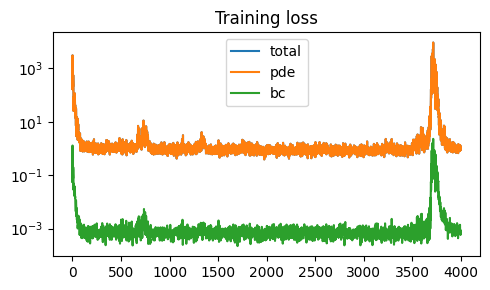

In [16]:
hist = []
t0 = time.time()
for it in range(1, steps+1):
    L, Lp, Lb = train_step()
    hist.append((L,Lp,Lb))
    if it % 200 == 0:
        print(f"iter {it:5d} | loss {L:.3e} (pde {Lp:.3e}, bc {Lb:.3e}) | {time.time()-t0:.1f}s")

plt.figure(figsize=(5,3))
plt.semilogy([h[0] for h in hist], label='total')
plt.semilogy([h[1] for h in hist], label='pde')
plt.semilogy([h[2] for h in hist], label='bc')
plt.legend(); plt.title('Training loss'); plt.tight_layout(); plt.show()


## Test on f(x)=sin x (domain [0,1])
Closed-form under u(0)=u(1)=0: set u(x)=A sin x + B sin(kx), with A=1/(k^2−1) (k≠1), B=−A·sin(1)/sin(k).


Relative L2 error vs analytic (f=sin, k=8.0): 1.036e+00


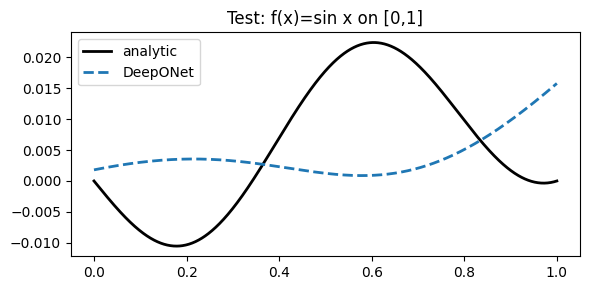

In [17]:
def analytic_u_sin01(x, k):
    A = 1.0/((k**2)-1.0)
    B = -A*math.sin(1.0)/math.sin(k)
    return A*torch.sin(x) + B*torch.sin(k*x)

def test_on_sin(k_test=8.0):
    # branch sensors for f(x)=sin x at x_sens = (xi+1)/2
    x_sens = (xi + 1.0)/2.0
    f_sens = torch.sin(x_sens).unsqueeze(0).to(device)
    x = torch.linspace(0, 1, 1000, device=device).unsqueeze(1)
    with torch.no_grad():
        u_hat = model(f_sens, x)
    u_ex = analytic_u_sin01(x, k_test).to(device)
    rel_l2 = torch.linalg.norm(u_hat - u_ex)/torch.linalg.norm(u_ex)
    print(f"Relative L2 error vs analytic (f=sin, k={k_test}): {rel_l2.item():.3e}")
    plt.figure(figsize=(6,3))
    plt.plot(x.cpu(), u_ex.cpu(), 'k-', lw=2, label='analytic')
    plt.plot(x.cpu(), u_hat.cpu(), '--', lw=2, label='DeepONet')
    plt.legend(); plt.title('Test: f(x)=sin x on [0,1]'); plt.tight_layout(); plt.show()

test_on_sin(8.0)


## Evaluate on a random forcing (unseen)


In [ ]:
def eval_random_case():
    coeffs = sample_random_f(1)
    x = torch.linspace(0,1,1000, device=device).unsqueeze(1)
    # branch sensors: values at t=xi (x_sens=(xi+1)/2)
    f_sens = cheb_eval(xi.view(-1,1), coeffs).squeeze(-1)  # (1,m)
    with torch.no_grad():
        f_x   = cheb_eval(2.0*x - 1.0, coeffs).squeeze(0)  # (1000,1)
        u_hat = model(f_sens, x)
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1); plt.plot(x.cpu(), f_x.cpu()); plt.title('Random f(x) on [0,1]')
    plt.subplot(1,2,2); plt.plot(x.cpu(), u_hat.cpu()); plt.title('u(x) predicted')
    plt.tight_layout(); plt.show()

eval_random_case()


## Save model (optional)


In [ ]:
torch.save({'model_state': model.state_dict(),
            'config': {'m_sensors': m_sensors, 'width': width, 'depth': depth}},
           'pi_deeponet_helmholtz_01.pt')
print('Saved to pi_deeponet_helmholtz_01.pt')
